# Análise de Comportamento de Bots Suspeitos

In [1]:
# dependências
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
from collections import Counter
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")

from util.load_graph import load_graph_by_edge, get_driver, get_user_property_keys, get_user_properties, get_property_values, get_property_values_for_users

In [2]:
driver = get_driver()

In [3]:
suspected_bots = pd.read_csv('../data/all_suspected_bots.csv')
suspected_bots

,user_id
0,578e96fd8494ee068f5a734791687de2
1,09d9e4475318b93fc669722d39fa122b
2,e3afed0047b08059d0fada10f400c1e5
3,0894f3397b0d3a06b7be5791fcffcb4f
4,92fb5fa7d278d7f1096cc2ac0171a491
...,...
177,b4a2c0a09761d5582f8ef1123718d434
178,e53d1f90e100d3e622ca3e261f816fc9
179,8421500a53d526b310d8ecb793772833
180,23035733991a406e82a6663723928f26


In [4]:
high_conf_suspected_bots = pd.read_csv('../data/highest_confident_bots.csv')
high_conf_suspected_bots

,user_id
0,fbbbfb737acb18812f7de2400841abc3


## Comparação Scores Gerais vs Suspeitos

In [5]:
def compare_property_averages(driver, suspected_bots_df, user_id_col='user_id'):
    sample_user = suspected_bots_df[user_id_col].iloc[0]
    properties = get_user_properties(driver, sample_user)

    results = []

    for prop, val in properties.items():
        if not isinstance(val, (int, float)):
            continue

        all_vals = get_property_values(driver, prop)
        susp_vals = get_property_values_for_users(
            driver, prop, suspected_bots_df[user_id_col]
        )

        if len(all_vals) == 0 or len(susp_vals) == 0:
            continue

        results.append({
            "property": prop,
            "avg_all_users": np.mean(all_vals),
            "avg_suspected_bots": np.mean(susp_vals),
            "ratio_susp_vs_all": np.mean(susp_vals) / np.mean(all_vals)
        })

    df = pd.DataFrame(results).sort_values(
        by="ratio_susp_vs_all", ascending=False
    )

    return df

In [6]:
compare_property_averages(driver, suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
6,viral_score,0.006145,0.148099,24.101426
3,misinfo_score,0.132189,1.035834,7.836008
5,shares_score,0.522397,3.111926,5.957015
2,metronome_score,0.094735,0.155737,1.643923
0,content_originality,0.936023,0.605857,0.647267
4,network_diversity,0.558277,0.303588,0.543795
1,content_uniqueness,0.705840,0.058867,0.083401


In [7]:
compare_property_averages(driver, high_conf_suspected_bots)

,property,avg_all_users,avg_suspected_bots,ratio_susp_vs_all
3,misinfo_score,0.132189,2.506505,18.961526
5,shares_score,0.522397,3.837399,7.345754
2,metronome_score,0.094735,0.591228,6.240849
6,synchronicity_score,9.805440,36.972293,3.770590
0,content_originality,0.936023,0.257443,0.275039
4,network_diversity,0.558277,0.112360,0.201261
1,content_uniqueness,0.705840,0.012154,0.017219
7,viral_score,0.006145,0.000000,0.000000


# Encontrar subcomunidades

## Tipos de Similaridade e Arquétipos de Bots

### 1. SYNC_SIMILAR (Intensidade de Coordenação)

**O que mede:**  
Conecta bots que possuem um **Score de Sincronicidade** semelhante (relaciona quantos conteúdos compartilhados com quantos usuários).

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Núcleo Central*.  
  Um grupo coeso de bots responsável pela explosão inicial e rápida de mensagens.

- **Comunidade de baixo score:** *Periferia*.  
  Bots que ficam para trás ou participam apenas de ondas menores e específicas.

---

### 2. METRONOME_SIMILAR (Impressão Digital Temporal)

**O que mede:**  
Conecta bots que compartilham o mesmo **Coeficiente de Variação** nos intervalos de postagem.

**Arquétipos de bots identificados:**

- **Comunidade A:** *Relógios*.  
  Bots com variância próxima de zero (extremamente robóticos).

- **Comunidade B:** *Mímicos*.  
  Bots configurados com um algoritmo específico de aleatorização para parecerem humanos (por exemplo, variância maior, porém idêntica entre si).

---

### 3. SHARES_SIMILAR (Perfil de Volume)

**O que mede:**  
Conecta bots com volume total de mensagens semelhante.

**Arquétipos de bots identificados:**

- **Comunidade de alto volume:** *Canhões de Spam*.  
  Projetados para inundar grupos.

- **Comunidade de baixo volume:** *Atiradores de Elite*.  
  Bots que postam raramente.

---

### 4. MISINFO_SIMILAR (Carga Útil: Desinformação)

**O que mede:**  
Conecta bots que dedicam uma proporção semelhante de sua atividade a mensagens com alto score de desinformação.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Especialistas em Desinformação*.  
  Contas criadas especificamente para espalhar narrativas direcionadas.

- **Comunidade de baixo score:** *Amplificadores Genéricos*.  
  Bots que amplificam conteúdo independentemente de sua veracidade.

---

### 5. VIRAL_SIMILAR (Carga Útil: Viralidade)

**O que mede:**  
Conecta bots com taxas de sucesso semelhantes na amplificação de conteúdo viral.

**Arquétipos de bots identificados:**

- **Comunidade de alto score:** *Amplificadores*.  
  Bots projetados para fazer conteúdos existentes virarem tendência.

- **Comunidade de baixo score:**  
  Bots que introduzem conteúdo que não se tornou viral.

---

### 6. CONTENT_ORIGINALITY_SIMILAR (Lógica de Repetição)

**O que mede:**  
Conecta bots com proporções semelhantes de **Textos Únicos / Total de Mensagens**.

**Arquétipos de bots identificados:**

- **Comunidade ~0.1 (Baixa):** *Drones de Copiar e Colar*.  
  Bots que encaminham exatamente o mesmo texto centenas de vezes.

- **Comunidade ~0.9 (Alta):** *Bots Generativos*.  
  Bots que alteram levemente o texto a cada postagem.

---

### 7. CONTENT_UNIQUENESS_SIMILAR (Efeito Câmara de Eco)

**O que mede:**  
Conecta bots com base no quão “mainstream” é o conteúdo que compartilham globalmente.

**Arquétipos de bots identificados:**

- **Comunidade de baixa singularidade:** *Câmara de Eco*.  
  Bots que compartilham apenas o que milhares de outras pessoas já estão compartilhando (reforço de consenso).

- **Comunidade de alta singularidade:** *Injetores*.  
  Bots que introduzem narrativas raras ou novas na rede.

---

### 8. NETWORK_DIVERSITY_SIMILAR (Estratégia de Implantação)

**O que mede:**  
Conecta bots com proporções semelhantes de **Grupos Únicos / Total de Parceiros**.

**Arquétipos de bots identificados:**

- **Comunidade de baixa diversidade:** *Bots Enxame*.  
  Conjunto de bots que atacam o mesmo pequeno grupo de comunidades, sobrecarregando um alvo específico.

- **Comunidade de alta diversidade:** *Bots Ponte*.  
  Bots que atuam como conectores, levando conteúdo de uma comunidade para outros grupos.


In [8]:
from statistics import mean, median

def add_group_score_stats(
    G,
    group_attr,
    score_attr,
    prefix=None,
    round_digits=4
):
    if prefix is None:
        prefix = group_attr

    group_scores = {}

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        score = data.get(score_attr)

        if group is None or score is None:
            continue

        group_scores.setdefault(group, []).append(score)

    group_stats = {}
    for g, scores in group_scores.items():
        if len(scores) == 0:
            continue
        group_stats[g] = {
            'mean': round(mean(scores), round_digits),
            'median': round(median(scores), round_digits)
        }

    for node, data in G.nodes(data=True):
        group = data.get(group_attr)
        if group in group_stats:
            data[f'{prefix}_mean_{score_attr}'] = group_stats[group]['mean']
            data[f'{prefix}_median_{score_attr}'] = group_stats[group]['median']


In [9]:
def classify_bot_behaviors(driver, suspected_bot_ids, output_dir='../data/visualization'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    similarity_graphs = {
        'SYNC_SIMILAR': ('synchronicity_score', 'Coordenação'),
        'METRONOME_SIMILAR': ('metronome_score', 'Variação temporal'),
        'SHARES_SIMILAR': ('shares_score', 'Compartilhamento'),
        'MISINFO_SIMILAR': ('misinfo_score', 'Desinformação'),
        'VIRAL_SIMILAR': ('viral_score', 'Viral'),
        'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade do conteúdo'),
        'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade do conteúdo'),
        'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade da rede')
    }
    
    bot_classifications = {}
    
    for graph_type, (score_name, behavior_name) in similarity_graphs.items():
        print(f"\nProcessando {graph_type}...")
        G = load_graph_by_edge(driver, graph_type)

        weights = list(nx.get_edge_attributes(G, 'weight').values())
        print("\nEstatísticas:")
        print("Arestas:", G.number_of_edges())
        if weights:
            print(f"Peso médio: {np.mean(weights):.4f}")
            print(f"Peso máximo: {np.max(weights):.4f}")
        else:
            print("Peso médio: 0.0")
            print("Peso máximo: 0.0")
        
        suspected_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_bots = G.subgraph(suspected_nodes).copy()
        
        if len(G_bots.nodes()) < 2:
            print(f"Pulando {graph_type}: Menos que 2 nós")
            continue
        
        # CONNECTED COMPONENTS
        components = list(nx.connected_components(G_bots))
        print(f"Achou {len(components)} componentes conectados")

        for comp_id, comp in enumerate(components):
            subgraph = G_bots.subgraph(comp)
            density = nx.density(subgraph)
            avg_weight = (
                sum(d['weight'] for _, _, d in subgraph.edges(data=True)) /
                max(subgraph.number_of_edges(), 1)
            )

            for node in comp:
                G_bots.nodes[node]['component_id'] = comp_id
                G_bots.nodes[node]['component_size'] = len(comp)
                G_bots.nodes[node]['component_density'] = round(density, 4)
                G_bots.nodes[node]['component_avg_weight'] = round(avg_weight, 4)
                G_bots.nodes[node]['behavior_type'] = behavior_name
        
        # LOUVAIN
        partition = community_louvain.best_partition(
            G_bots,
            weight="weight",
            random_state=42
        )

        community_sizes = Counter(partition.values())

        for node, comm_id in partition.items():
            G_bots.nodes[node]["louvain_community"] = comm_id
            G_bots.nodes[node]["louvain_community_size"] = community_sizes[comm_id]

            if node not in bot_classifications:
                bot_classifications[node] = {}
            bot_classifications[node][behavior_name] = comm_id


        num_communities = len(set(partition.values()))
        community_sizes = Counter(partition.values())
        print(f"Número de comunidades louvain: {num_communities}")
        print("Tamanho das comunidades (top 10):")
        for cid, size in community_sizes.most_common(10):
            print(f"Comunidade {cid}: {size} nós")

        # K-CORE
        try:
            core_numbers = nx.core_number(G_bots)
            for node, core in core_numbers.items():
                G_bots.nodes[node]['k_core'] = core
        except nx.NetworkXError:
            for node in G_bots.nodes():
                G_bots.nodes[node]['k_core'] = 0
        
        for node in G_bots.nodes():
            G_bots.nodes[node]['degree'] = G_bots.degree(node, weight='weight')

        add_group_score_stats(
            G_bots,
            group_attr='component_id',
            score_attr=score_name,
            prefix='component'
        )
        add_group_score_stats(
            G_bots,
            group_attr='louvain_community',
            score_attr=score_name,
            prefix='louvain'
        )
        
        gexf_filename = os.path.join(output_dir, f'{graph_type.lower()}_bot_communities.gexf')
        nx.write_gexf(G_bots, gexf_filename)
        print(f"  -> Salvou {gexf_filename}")
        print()
    
    if bot_classifications:
        df = pd.DataFrame.from_dict(bot_classifications, orient='index')
        df.index.name = 'user_id'
        df = df.reset_index()
        
        csv_filename = os.path.join(output_dir, 'bot_behavior_classifications.csv')
        df.to_csv(csv_filename, index=False)
        print(f"Salvo classificações {csv_filename}")
        
        return df
    else:
        return pd.DataFrame()

In [10]:
classify_bot_behaviors(driver, set(suspected_bots['user_id'].astype(str)))


Processando SYNC_SIMILAR...

Estatísticas:
Arestas: 29374
Peso médio: 0.9999
Peso máximo: 1.0000
Achou 18 componentes conectados
Número de comunidades louvain: 18
Tamanho das comunidades (top 10):
Comunidade 1: 18 nós
Comunidade 0: 17 nós
Comunidade 4: 15 nós
Comunidade 9: 8 nós
Comunidade 7: 7 nós
Comunidade 8: 7 nós
Comunidade 12: 7 nós
Comunidade 2: 6 nós
Comunidade 3: 6 nós
Comunidade 10: 5 nós
  -> Salvou ../data/visualization/sync_similar_bot_communities.gexf


Processando METRONOME_SIMILAR...

Estatísticas:
Arestas: 1017
Peso médio: 0.2962
Peso máximo: 0.6466
Achou 7 componentes conectados
Número de comunidades louvain: 10
Tamanho das comunidades (top 10):
Comunidade 5: 14 nós
Comunidade 2: 10 nós
Comunidade 0: 6 nós
Comunidade 3: 5 nós
Comunidade 1: 4 nós
Comunidade 6: 3 nós
Comunidade 9: 2 nós
Comunidade 7: 2 nós
Comunidade 4: 1 nós
Comunidade 8: 1 nós
  -> Salvou ../data/visualization/metronome_similar_bot_communities.gexf


Processando SHARES_SIMILAR...

Estatísticas:
Arest

,user_id,Coordenação,Compartilhamento,Singularidade do conteúdo,Diversidade da rede,Desinformação,Originalidade do conteúdo,Viral,Variação temporal
0,b4a2c0a09761d5582f8ef1123718d434,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
1,39cbaa62b92a0e15533df93733bad5aa,1.0,6.0,12.0,4.0,0.0,NaN,NaN,NaN
2,9ed48d49e811163bbf2e534fb1e6c4fd,2.0,9.0,20.0,13.0,2.0,NaN,NaN,NaN
3,0d6fa127c40dad71851f89be502b66b1,0.0,6.0,44.0,10.0,NaN,8.0,NaN,NaN
4,39ee10516124280a22f1798f2a41f9a7,3.0,3.0,NaN,13.0,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
177,611432c71777bf050c93682d85122dd4,NaN,6.0,30.0,14.0,NaN,0.0,NaN,NaN
178,3f64a652deccf6273d7d769252bdfb46,NaN,NaN,35.0,14.0,NaN,3.0,NaN,1.0
179,abe534d581ec6d552243d6955d3c3cd8,NaN,NaN,35.0,7.0,NaN,18.0,NaN,7.0
180,de760dae043e718d950621477b51111a,NaN,NaN,46.0,NaN,NaN,35.0,NaN,5.0


## Visualização de Clustering Coefficient

In [11]:
def visualize_clustering_analysis(driver, suspected_bot_ids, output_dir='../data/visualization'):
    os.makedirs(output_dir, exist_ok=True)
    
    similarity_graphs = {
        'SYNC_SIMILAR': ('synchronicity_score', 'Coordenação'),
        'METRONOME_SIMILAR': ('metronome_score', 'Variação temporal'),
        'SHARES_SIMILAR': ('shares_score', 'Compartilhamento'),
        'MISINFO_SIMILAR': ('misinfo_score', 'Desinformação'),
        'VIRAL_SIMILAR': ('viral_score', 'Viral'),
        'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade'),
        'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade'),
        'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade')
    }
    
    clustering_data = []
    
    for graph_type, (score_name, behavior_name) in similarity_graphs.items():
        print(f"Analisando clustering em {graph_type}...")
        
        G = load_graph_by_edge(driver, graph_type)
        suspected_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_bots = G.subgraph(suspected_nodes).copy()
        
        if len(G_bots.nodes()) < 3:
            continue
        
        try:
            clustering = nx.clustering(G_bots, weight='weight')
            avg_clustering = nx.average_clustering(G_bots, weight='weight')
            
            for node, coef in clustering.items():
                clustering_data.append({
                    'user_id': node,
                    'graph_type': behavior_name,
                    'clustering_coefficient': coef,
                    'avg_clustering': avg_clustering
                })
                
        except Exception as e:
            print(f"Erro em {graph_type}: {e}")
            continue
    
    df_clustering = pd.DataFrame(clustering_data)
    
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    df_clustering.boxplot(column='clustering_coefficient', by='graph_type', ax=plt.gca())
    plt.title('Distribuição do Clustering Coefficient por Tipo de Comportamento')
    plt.xlabel('Tipo de Comportamento')
    plt.ylabel('Clustering Coefficient')
    plt.xticks(rotation=45, ha='right')
    plt.suptitle('')
    
    plt.subplot(2, 2, 2)
    sns.violinplot(data=df_clustering, x='graph_type', y='clustering_coefficient')
    plt.title('Densidade da Distribuição do Clustering')
    plt.xlabel('Tipo de Comportamento')
    plt.ylabel('Clustering Coefficient')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(2, 2, 3)
    avg_by_type = df_clustering.groupby('graph_type')['clustering_coefficient'].mean().sort_values(ascending=False)
    avg_by_type.plot(kind='barh', color='steelblue')
    plt.title('Clustering Coefficient Médio por Tipo')
    plt.xlabel('Clustering Coefficient Médio')
    plt.ylabel('Tipo de Comportamento')
    
    plt.subplot(2, 2, 4)
    plt.hist(df_clustering['clustering_coefficient'], bins=50, color='coral', edgecolor='black')
    plt.title('Distribuição Geral do Clustering Coefficient')
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('Frequência')
    plt.axvline(df_clustering['clustering_coefficient'].mean(), color='red', 
                linestyle='--', label=f'Média: {df_clustering["clustering_coefficient"].mean():.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(14, 10))
    
    pivot_data = df_clustering.pivot_table(
        index='user_id', 
        columns='graph_type', 
        values='clustering_coefficient',
        aggfunc='mean'
    )
    
    # Seleciona top 50 bots com maior variação
    pivot_std = pivot_data.std(axis=1).sort_values(ascending=False)
    top_bots = pivot_std.head(50).index
    
    sns.heatmap(
        pivot_data.loc[top_bots], 
        cmap='RdYlGn', 
        center=0.5,
        annot=False,
        fmt='.2f',
        cbar_kws={'label': 'Clustering Coefficient'}
    )
    plt.title('Perfil de Clustering: Top 50 Bots com Maior Variação', fontsize=14)
    plt.xlabel('Tipo de Comportamento')
    plt.ylabel('Bot ID')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, (graph_type, (score_name, behavior_name)) in enumerate(similarity_graphs.items()):
        if idx >= len(axes):
            break
            
        G = load_graph_by_edge(driver, graph_type)
        suspected_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_bots = G.subgraph(suspected_nodes).copy()
        
        if len(G_bots.nodes()) < 3:
            continue
        
        try:
            clustering = nx.clustering(G_bots, weight='weight')
            scores = []
            clusterings = []
            
            for node in G_bots.nodes():
                score = G_bots.nodes[node].get(score_name, 0)
                if score > 0:
                    scores.append(score)
                    clusterings.append(clustering.get(node, 0))
            
            axes[idx].scatter(scores, clusterings, alpha=0.6, s=30)
            axes[idx].set_xlabel(f'{behavior_name} Score')
            axes[idx].set_ylabel('Clustering Coefficient')
            axes[idx].set_title(f'{behavior_name}')
            axes[idx].grid(True, alpha=0.3)
            
            if len(scores) > 1:
                z = np.polyfit(scores, clusterings, 1)
                p = np.poly1d(z)
                axes[idx].plot(sorted(scores), p(sorted(scores)), "r--", alpha=0.8, linewidth=2)
            
        except Exception as e:
            axes[idx].text(0.5, 0.5, f'Erro: {str(e)}', ha='center', va='center')
    
    plt.suptitle('Relação entre Score e Clustering Coefficient', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_vs_scores.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(14, 8))
    
    def categorize_clustering(row):
        high_count = sum(row > 0.7)
        low_count = sum(row < 0.3)
        
        if high_count >= 5:
            return 'Enxame Coordenado'
        elif low_count >= 5:
            return 'Bot Ponte'
        elif high_count >= 3:
            return 'Célula Especializada'
        else:
            return 'Comportamento Misto'
    
    pivot_data['archetype'] = pivot_data.apply(categorize_clustering, axis=1)
    
    archetype_counts = pivot_data['archetype'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
    
    plt.pie(archetype_counts.values, labels=archetype_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Distribuição de Arquétipos Baseados em Clustering', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_archetypes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    archetypes = pivot_data['archetype'].unique()
    
    for idx, archetype in enumerate(archetypes[:4]):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        
        # Dados para o radar
        archetype_data = pivot_data[pivot_data['archetype'] == archetype].drop(columns=['archetype']).mean()
        #archetype_data = pivot_data[pivot_data['archetype'] == archetype].mean()
        categories = list(archetype_data.index[:-1]) 
        values = list(archetype_data.values[:-1])
        
        values += values[:1]
        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]
        
        ax = plt.subplot(2, 2, idx + 1, projection='polar')
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=8)
        ax.set_ylim(0, 1)
        ax.set_title(f'{archetype}\n({archetype_counts[archetype]} bots)', 
                     size=12, pad=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    df_clustering.to_csv(f'{output_dir}/clustering_analysis.csv', index=False)
    pivot_data.to_csv(f'{output_dir}/clustering_profiles.csv')
    
    print(f"\n✓ Análise completa salva em {output_dir}/")
    print(f"✓ {len(df_clustering)} medições de clustering coletadas")
    print(f"✓ {len(pivot_data)} bots perfilados")
    
    return df_clustering, pivot_data

Analisando clustering em SYNC_SIMILAR...
Analisando clustering em METRONOME_SIMILAR...
Analisando clustering em SHARES_SIMILAR...
Analisando clustering em MISINFO_SIMILAR...
Analisando clustering em VIRAL_SIMILAR...
Analisando clustering em CONTENT_ORIGINALITY_SIMILAR...
Analisando clustering em CONTENT_UNIQUENESS_SIMILAR...
Analisando clustering em NETWORK_DIVERSITY_SIMILAR...


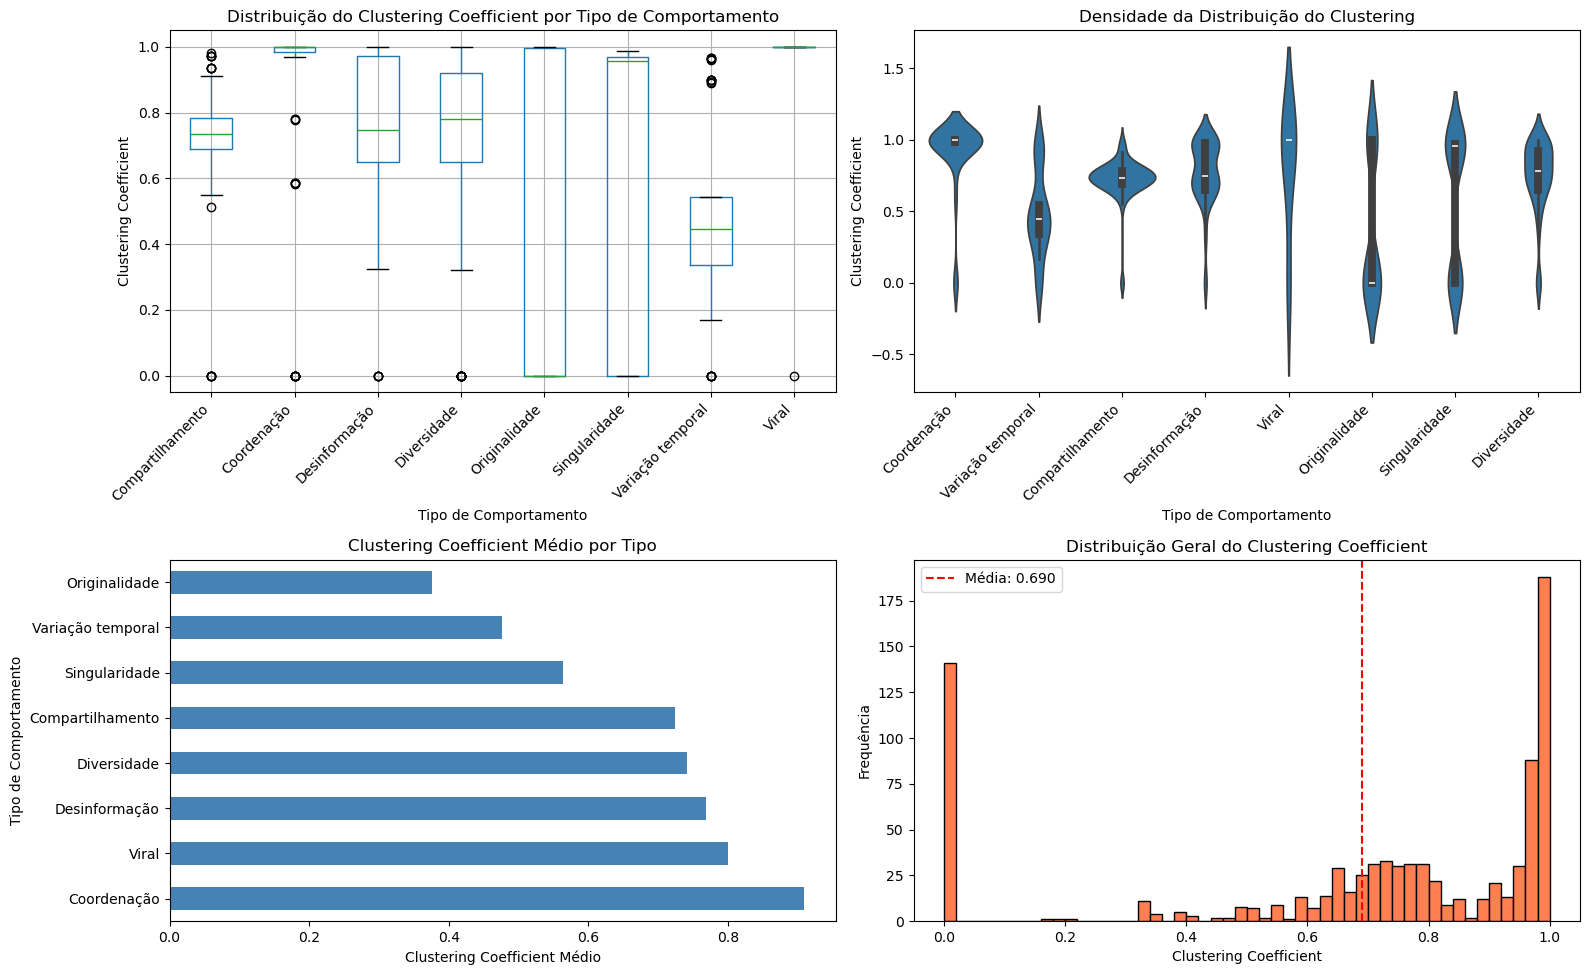

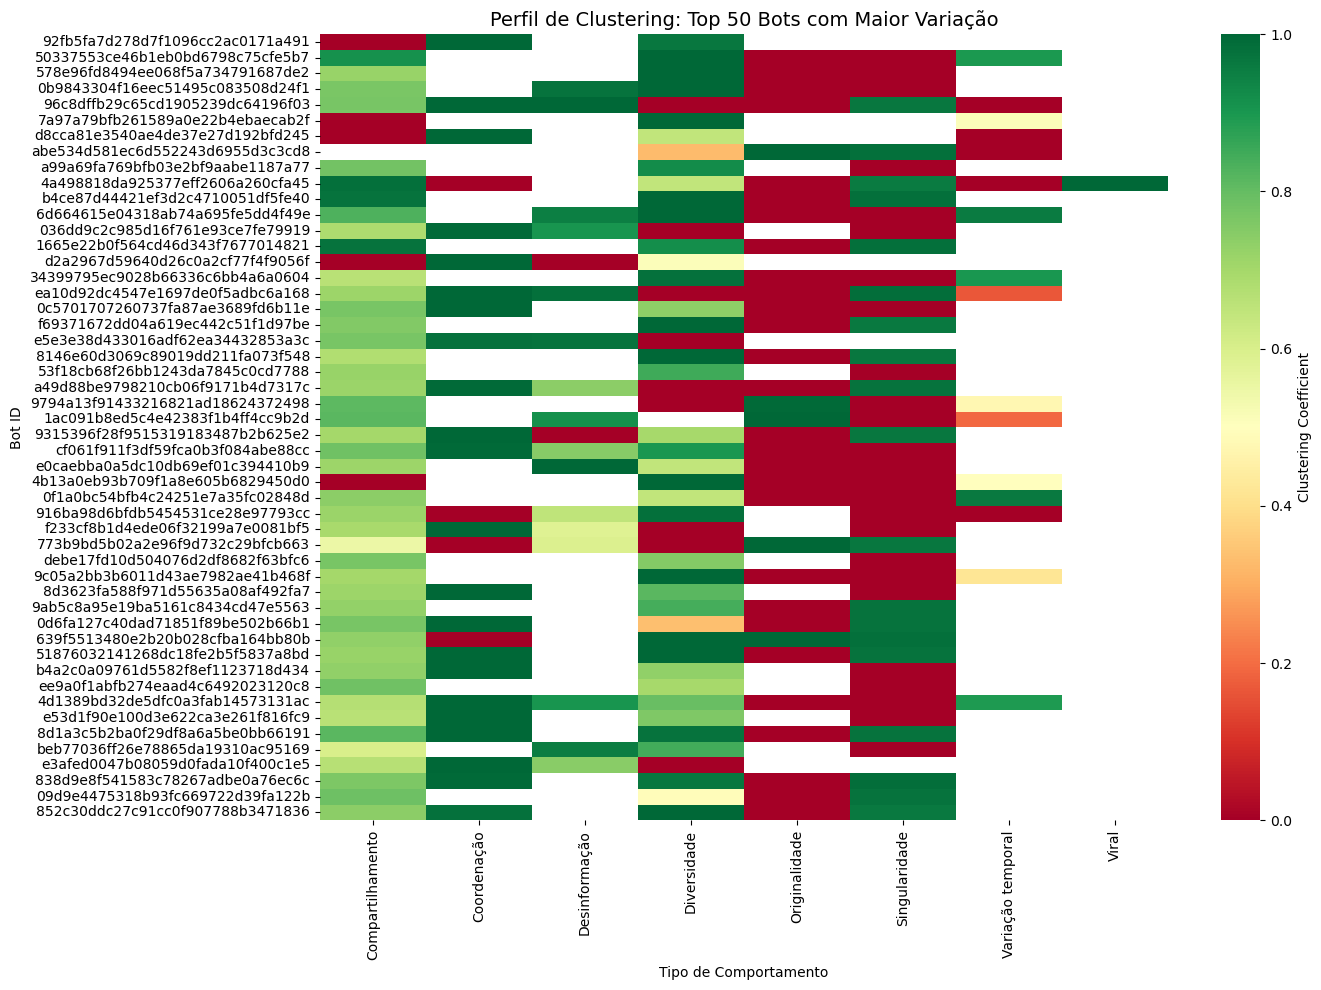

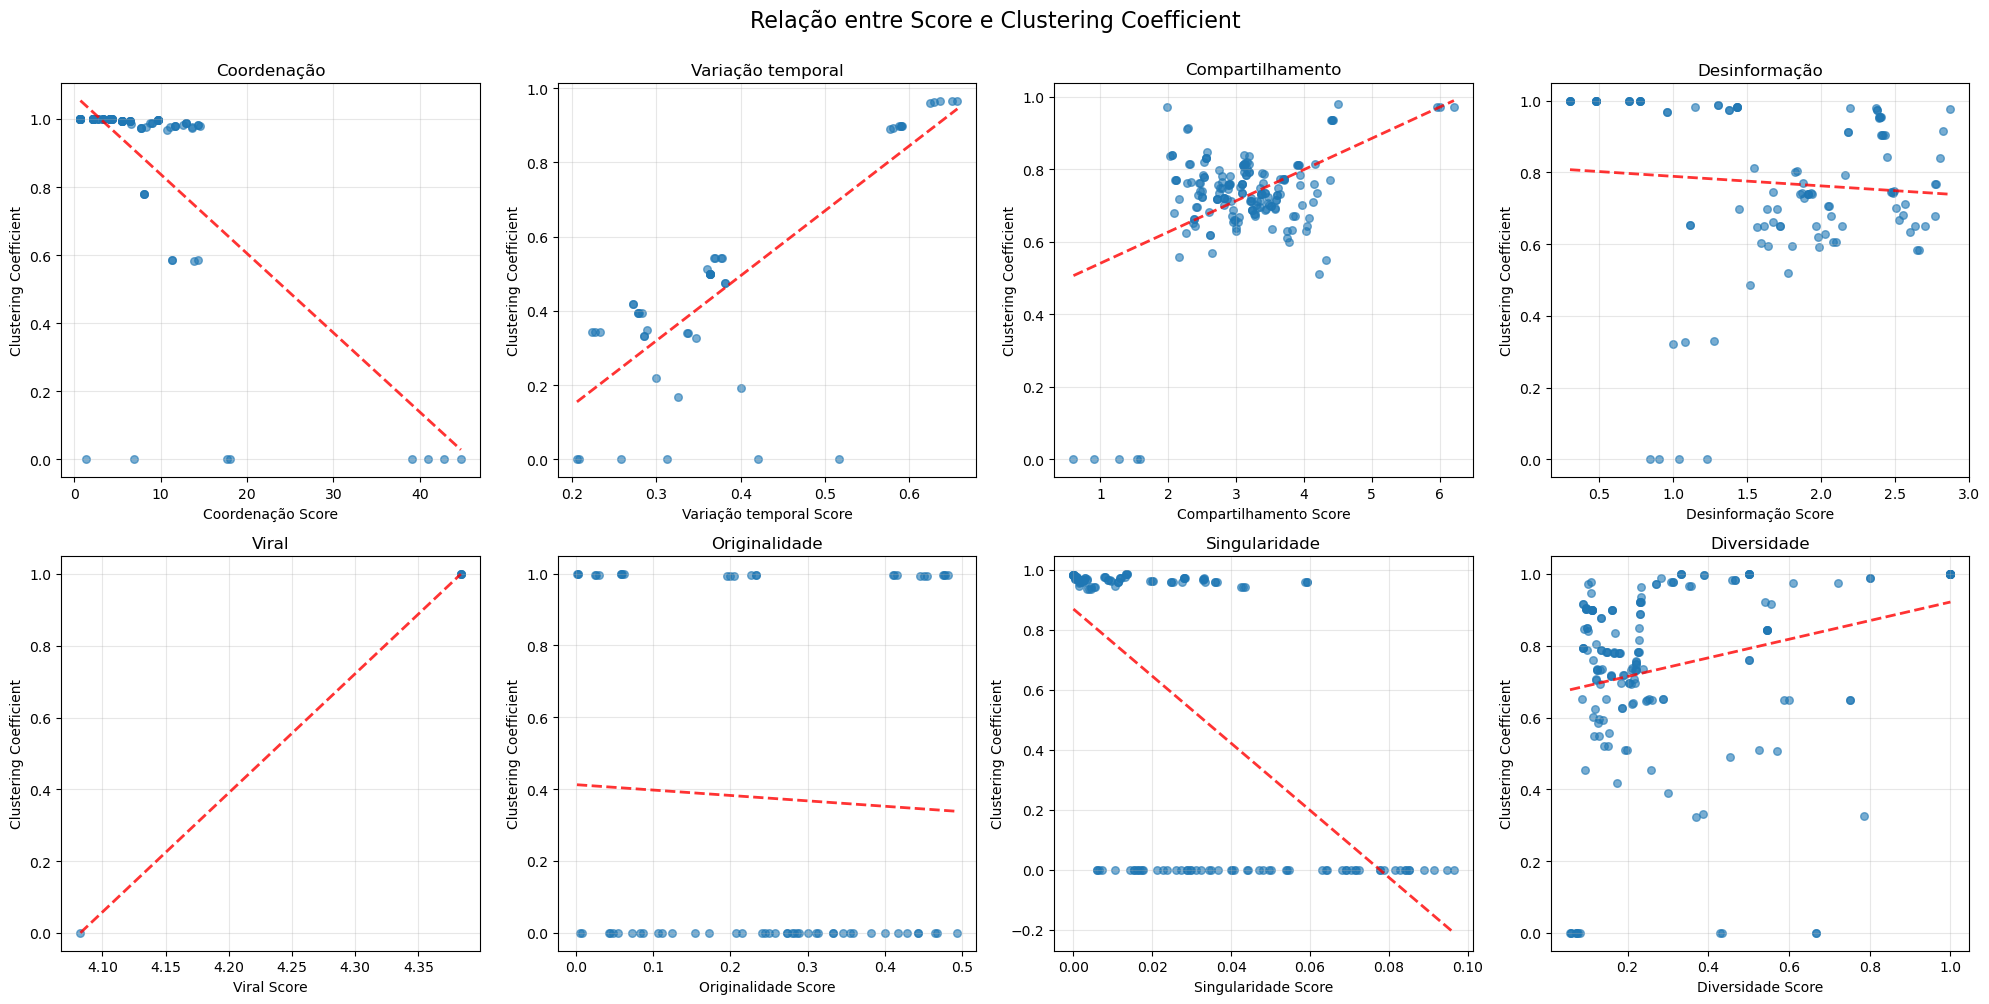

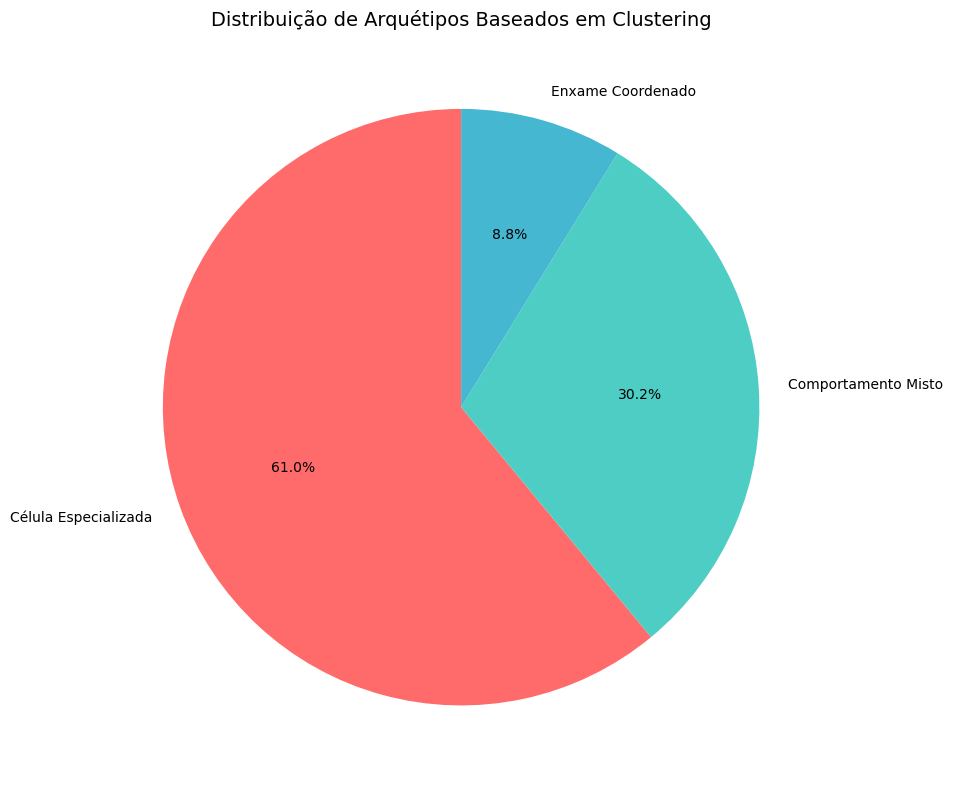

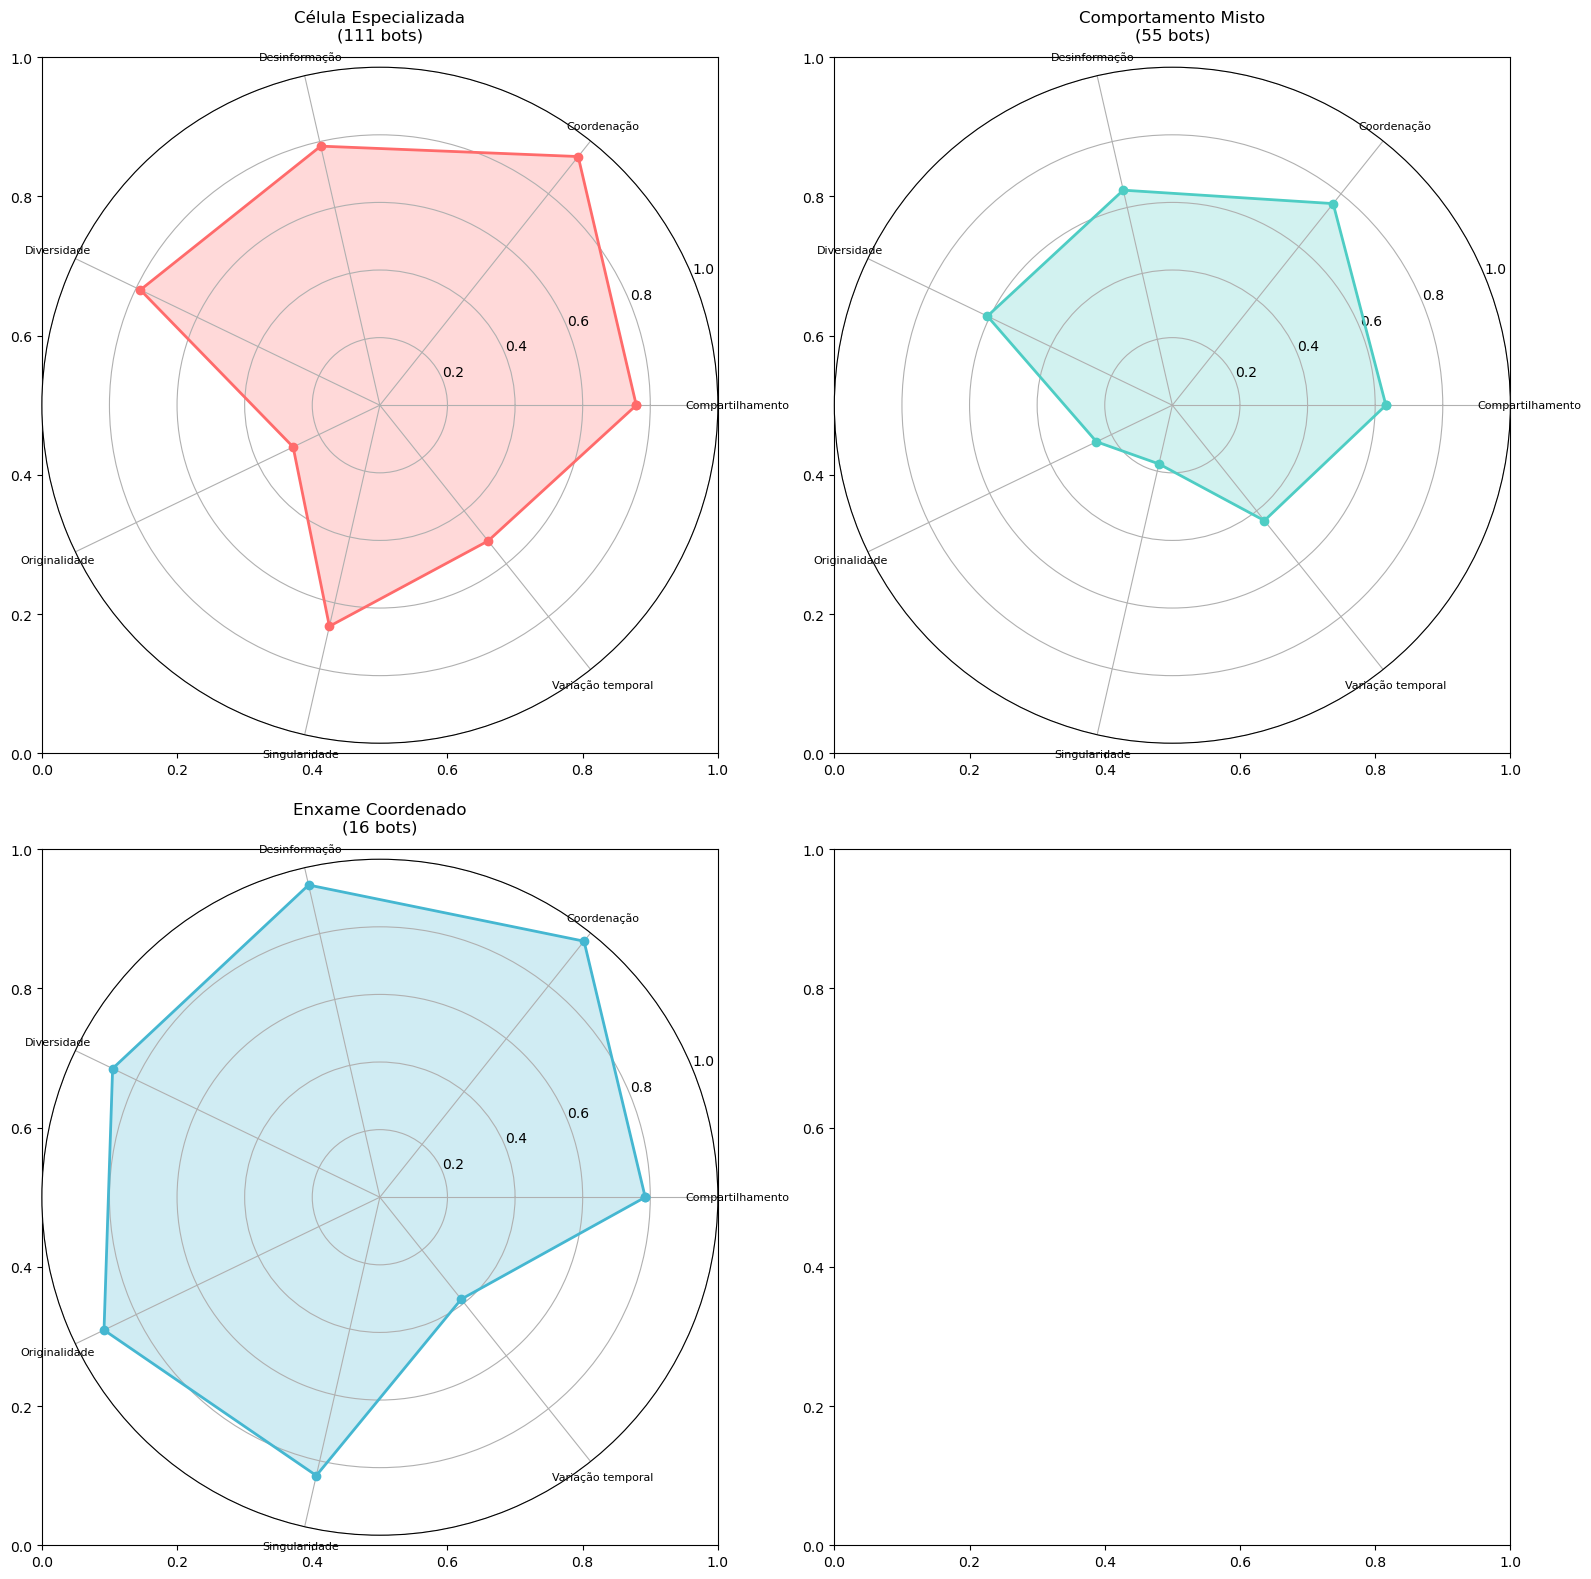


✓ Análise completa salva em ../data/visualization/
✓ 855 medições de clustering coletadas
✓ 182 bots perfilados


In [12]:
df_clust, profiles = visualize_clustering_analysis(
    driver, 
    set(suspected_bots['user_id'].astype(str))
)

## Categorização em arquétipos

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

similarity_graphs = {
    'SYNC_SIMILAR': ('synchronicity', 'Coordenação', 'synchronicity_score'),
    'METRONOME_SIMILAR': ('metronome', 'Variação temporal', 'metronome_score'),
    'SHARES_SIMILAR': ('shares', 'Volume de Compartilhamento', 'shares_score'),
    'MISINFO_SIMILAR': ('misinfo', 'Desinformação', 'misinfo_score'),
    'VIRAL_SIMILAR': ('viral', 'Viralidade', 'viral_score'),
    'CONTENT_UNIQUENESS_SIMILAR': ('content_uniqueness', 'Singularidade', 'content_uniqueness'),
    'NETWORK_DIVERSITY_SIMILAR': ('network_diversity', 'Diversidade de grupos', 'network_diversity'),
    'CONTENT_ORIGINALITY_SIMILAR': ('content_originality', 'Originalidade', 'content_originality')
}

def build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs):
    print(f"--- Iniciando Mineração de {len(suspected_bot_ids)} suspeitos ---")
    
    user_features = {uid: {} for uid in suspected_bot_ids}
    
    for graph_type, (prefix, behavior_name, neo4j_prop) in similarity_graphs.items():
        print(f"Carregando grafo: {graph_type} ({behavior_name})...")
        
        G = load_graph_by_edge(driver, graph_type)
        
        relevant_nodes = [n for n in G.nodes() if n in suspected_bot_ids]
        G_sub = G.subgraph(relevant_nodes).copy()
        
        if len(G_sub) == 0:
            print(f"Nenhum bot suspeito encontrado na camada {graph_type}")
            for uid in suspected_bot_ids:
                #user_features[uid][f'{prefix}_centrality'] = 0
                user_features[uid][f'{prefix}_density'] = 0
                #user_features[uid][f'{prefix}_group_size'] = 0
                user_features[uid][f'{prefix}_score'] = 0
            continue

        # Calcula degree centrality
        centrality = nx.degree_centrality(G_sub)
        
        # Calcula densidade das componentes
        components = list(nx.connected_components(G_sub))
        node_density_map = {}
        node_size_map = {}
        for comp in components:
            comp_sub = G_sub.subgraph(comp)
            try:
                d = nx.density(comp_sub) 
            except:
                d = 0
            s = len(comp)
            for node in comp:
                node_density_map[node] = d
                node_size_map[node] = s
        
        # Mapeia features
        for uid in suspected_bot_ids:
            u_cent = 0
            u_dens = 0
            u_size = 0
            u_score = 0
            if uid in G_sub:
                u_cent = centrality.get(uid, 0)
                u_dens = node_density_map.get(uid, 0)
                u_size = node_size_map.get(uid, 0)
                
                u_score = G_sub.nodes[uid].get(neo4j_prop, 0)
                
            #user_features[uid][f'{prefix}_centrality'] = u_cent
            user_features[uid][f'{prefix}_density'] = u_dens
            #user_features[uid][f'{prefix}_group_size'] = u_size
            user_features[uid][f'{prefix}_score'] = u_score

    df = pd.DataFrame.from_dict(user_features, orient='index')
    return df.fillna(0)

In [14]:
def hdbscan_comprehensive_search(df_features):    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_features)
    
    n_samples = len(df_features)
    
    param_grid = {
        'min_cluster_size': [3, 5, 8, 10, 15],
        'min_samples': [1, 2, 3, 5],
        'cluster_selection_method': ['eom', 'leaf'],
        'cluster_selection_epsilon': [0.0, 0.2, 0.5]
    }
    
    results = []
    total = (len(param_grid['min_cluster_size']) * 
             len(param_grid['min_samples']) * 
             len(param_grid['cluster_selection_method']) * 
             len(param_grid['cluster_selection_epsilon']))
    
    print(f"Testando {total} combinações...\n")
    count = 0
    
    for mcs in param_grid['min_cluster_size']:
        for ms in param_grid['min_samples']:
            for method in param_grid['cluster_selection_method']:
                for eps in param_grid['cluster_selection_epsilon']:
                    count += 1
                    
                    clusterer = HDBSCAN(
                        min_cluster_size=mcs,
                        min_samples=ms,
                        cluster_selection_method=method,
                        cluster_selection_epsilon=eps
                    )
                    
                    labels = clusterer.fit_predict(df_scaled)
                    
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                    n_noise = list(labels).count(-1)
                    noise_pct = (n_noise / len(labels)) * 100
                    
                    if n_clusters > 1 and n_noise < len(labels):
                        mask = labels != -1
                        silhouette = silhouette_score(df_scaled[mask], labels[mask])
                    else:
                        silhouette = -1
                    
                    results.append({
                        'min_cluster_size': mcs,
                        'min_samples': ms,
                        'method': method,
                        'epsilon': eps,
                        'n_clusters': n_clusters,
                        'noise_pct': noise_pct,
                        'silhouette': silhouette
                    })
                    
                    if count % 10 == 0:
                        print(f"Progresso: {count}/{total} ({count/total*100:.0f}%)")
    
    df_results = pd.DataFrame(results)
    
    df_valid = df_results[
        (df_results['n_clusters'] >= 2) & 
        (df_results['silhouette'] > 0)
    ].copy()
    
    df_valid['balanced_score'] = (
        df_valid['silhouette'] * 0.5 +  # 50% peso para qualidade
        (100 - df_valid['noise_pct']) / 100 * 0.5  # 50% peso para baixo ruído
    )
    
    top10 = df_valid.nlargest(10, 'balanced_score')
    
    print(f"\n{'='*90}")
    print(f"TOP 10 CONFIGURAÇÕES")
    print(f"{'='*90}")
    print(top10[['min_cluster_size', 'min_samples', 'method', 'epsilon', 
                 'n_clusters', 'noise_pct', 'silhouette', 'balanced_score']].to_string(index=False))
    print(f"{'='*90}\n")
    
    best = top10.iloc[0]
    
    print(f"RECOMENDAÇÃO:")
    print(f"min_cluster_size={int(best['min_cluster_size'])}")
    print(f"min_samples={int(best['min_samples'])}")
    print(f"cluster_selection_method='{best['method']}'")
    print(f"cluster_selection_epsilon={best['epsilon']}")
    print(f"\nResultado: {int(best['n_clusters'])} clusters, {best['noise_pct']:.1f}% ruído, sil={best['silhouette']:.3f}\n")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scatter = ax.scatter(
        top10['noise_pct'],
        top10['silhouette'],
        s=top10['n_clusters']*50,
        c=range(len(top10)),
        cmap='RdYlGn_r',
        alpha=0.7,
        edgecolors='black',
        linewidth=2
    )
    
    for idx, row in top10.iterrows():
        ax.annotate(
            f"{row['method'][:1]}\nε={row['epsilon']:.1f}",
            (row['noise_pct'], row['silhouette']),
            fontsize=8,
            ha='center'
        )
    
    ax.set_xlabel('% Ruído', fontsize=12)
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title('Top 10 Configurações', fontsize=14)
    ax.axhline(y=0.5, linestyle='--', color='green', alpha=0.3)
    ax.axvline(x=20, linestyle='--', color='green', alpha=0.3)
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Ranking (0=melhor)')
    plt.tight_layout()
    plt.show()
    
    return df_results, best

In [15]:
def apply_best_hdbscan(df_features, min_cluster_size=15, min_samples=1, 
                       cluster_selection_epsilon=0.0):
    print(f"Aplicando HDBSCAN com:")
    print(f"  min_cluster_size={min_cluster_size}")
    print(f"  min_samples={min_samples}")
    print(f"  cluster_selection_epsilon={cluster_selection_epsilon}\n")
    
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_features),
        columns=df_features.columns,
        index=df_features.index
    )
    
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_method='eom',
        cluster_selection_epsilon=cluster_selection_epsilon
    )
    
    labels = clusterer.fit_predict(df_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = (n_noise / len(labels)) * 100
    
    print(f"{n_clusters} clusters identificados")
    print(f"{n_noise} pontos como ruído ({noise_pct:.1f}%)")
    
    df_features_clustered = df_features.copy()
    df_features_clustered['Archetype_ID'] = labels
    
    archetype_dna = df_features_clustered[
        df_features_clustered['Archetype_ID'] != -1
    ].groupby('Archetype_ID')[df_features.columns].mean()
    
    cluster_counts = df_features_clustered['Archetype_ID'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        if cluster_id == -1:
            print(f"  Ruído: {count} bots ({count/len(df_features)*100:.1f}%)")
        else:
            print(f"  Cluster {cluster_id}: {count} bots ({count/len(df_features)*100:.1f}%)")
    
    return df_features_clustered, archetype_dna, clusterer


def visualize_archetypes_hdbscan(archetype_dna, df_features_clustered=None):
    fig = plt.figure(figsize=(14, 8))
    
    scaler = MinMaxScaler()
    dna_scaled = pd.DataFrame(
        scaler.fit_transform(archetype_dna),
        columns=archetype_dna.columns,
        index=archetype_dna.index
    )
    
    if df_features_clustered is not None:
        cluster_sizes = df_features_clustered[
            df_features_clustered['Archetype_ID'] != -1
        ]['Archetype_ID'].value_counts().sort_index()
        
        new_labels = [
            f"Cluster {idx} (n={cluster_sizes[idx]})"
            for idx in dna_scaled.index
        ]
        dna_scaled.index = new_labels
    
    sns.heatmap(
        dna_scaled.T,
        cmap='RdYlBu_r',
        annot=True,
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Intensidade Normalizada'}
    )
    
    plt.title("DNA Comportamental dos Bots", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Arquétipo", fontsize=12)
    plt.ylabel("Características", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return dna_scaled


def visualize_cluster_profiles(archetype_dna, df_features_clustered):    
    n_clusters = len(archetype_dna)
    features = archetype_dna.columns.tolist()
    n_features = len(features)
    
    scaler = MinMaxScaler()
    dna_scaled = pd.DataFrame(
        scaler.fit_transform(archetype_dna),
        columns=features,
        index=archetype_dna.index
    )
    
    cluster_sizes = df_features_clustered[
        df_features_clustered['Archetype_ID'] != -1
    ]['Archetype_ID'].value_counts().sort_index()
    
    angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
    angles += angles[:1]
    
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 5), 
                             subplot_kw=dict(projection='polar'))
    
    if n_clusters == 1:
        axes = [axes]
    
    colors = plt.cm.Set2(range(n_clusters))
    
    for idx, (cluster_id, ax) in enumerate(zip(dna_scaled.index, axes)):
        values = dna_scaled.loc[cluster_id].tolist()
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx])
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, size=8)
        ax.set_ylim(0, 1)
        ax.set_title(f"Cluster {cluster_id}\n({cluster_sizes[cluster_id]} bots)", 
                     size=12, fontweight='bold', pad=20)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


def analyze_noise_points(df_features_clustered):
    noise_data = df_features_clustered[df_features_clustered['Archetype_ID'] == -1]
    cluster_data = df_features_clustered[df_features_clustered['Archetype_ID'] != -1]
    
    if len(noise_data) == 0:
        return
    
    print(f"ANÁLISE DOS PONTOS DE RUÍDO ({len(noise_data)} bots)")
    
    comparison = pd.DataFrame({
        'Ruído (média)': noise_data[df_features_clustered.columns[:-1]].mean(),
        'Clusters (média)': cluster_data[df_features_clustered.columns[:-1]].mean(),
        'Diferença': noise_data[df_features_clustered.columns[:-1]].mean() - 
                     cluster_data[df_features_clustered.columns[:-1]].mean()
    })
    
    comparison['Diferença %'] = (comparison['Diferença'] / comparison['Clusters (média)'] * 100).round(1)
    
    print(comparison.to_string())

--- Iniciando Mineração de 182 suspeitos ---
Carregando grafo: SYNC_SIMILAR (Coordenação)...
Carregando grafo: METRONOME_SIMILAR (Variação temporal)...
Carregando grafo: SHARES_SIMILAR (Volume de Compartilhamento)...
Carregando grafo: MISINFO_SIMILAR (Desinformação)...
Carregando grafo: VIRAL_SIMILAR (Viralidade)...
Carregando grafo: CONTENT_UNIQUENESS_SIMILAR (Singularidade)...
Carregando grafo: NETWORK_DIVERSITY_SIMILAR (Diversidade de grupos)...
Carregando grafo: CONTENT_ORIGINALITY_SIMILAR (Originalidade)...
Testando 120 combinações...

Progresso: 10/120 (8%)
Progresso: 20/120 (17%)
Progresso: 30/120 (25%)
Progresso: 40/120 (33%)
Progresso: 50/120 (42%)
Progresso: 60/120 (50%)
Progresso: 70/120 (58%)
Progresso: 80/120 (67%)
Progresso: 90/120 (75%)
Progresso: 100/120 (83%)
Progresso: 110/120 (92%)
Progresso: 120/120 (100%)

TOP 10 CONFIGURAÇÕES
 min_cluster_size  min_samples method  epsilon  n_clusters  noise_pct  silhouette  balanced_score
               15            1    eom     

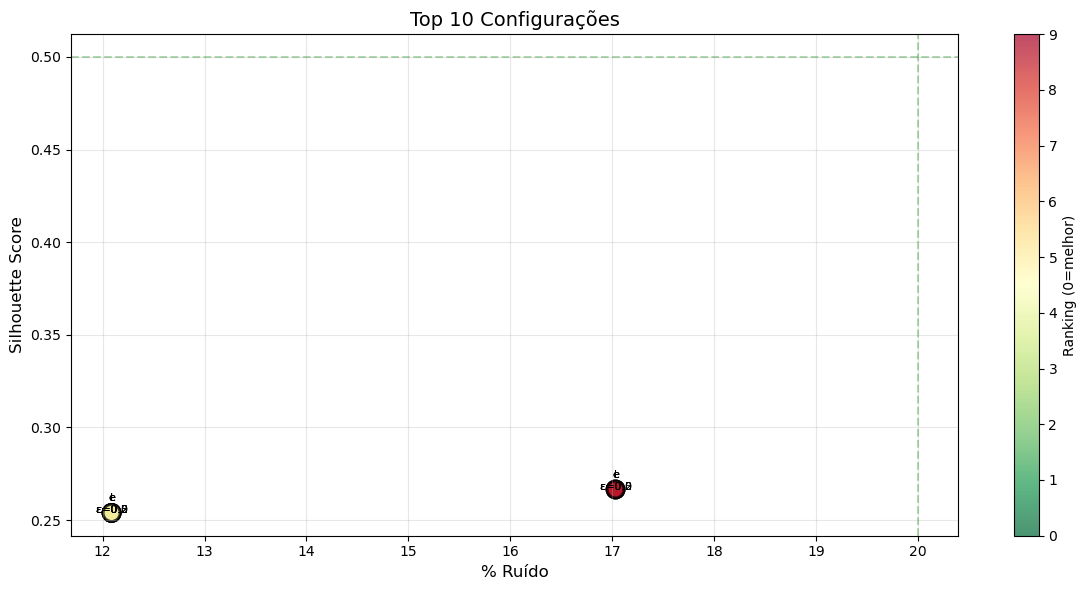

In [16]:
suspected_bot_ids = set(suspected_bots['user_id'].astype(str))
df_bots = build_bot_archetypes(driver, suspected_bot_ids, similarity_graphs)

results = hdbscan_comprehensive_search(df_bots)

Aplicando HDBSCAN com:
  min_cluster_size=15
  min_samples=1
  cluster_selection_epsilon=0.0

3 clusters identificados
22 pontos como ruído (12.1%)
  Ruído: 22 bots (12.1%)
  Cluster 0: 43 bots (23.6%)
  Cluster 1: 48 bots (26.4%)
  Cluster 2: 69 bots (37.9%)


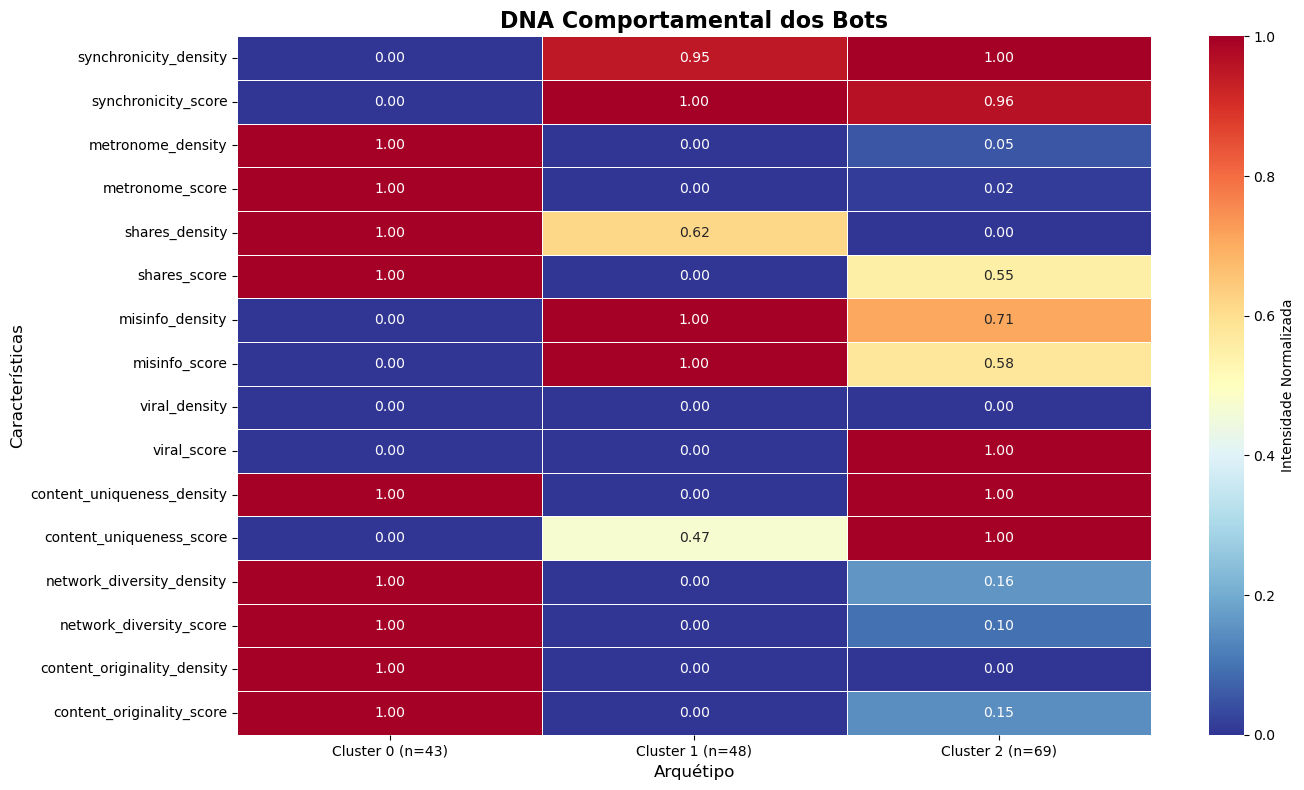

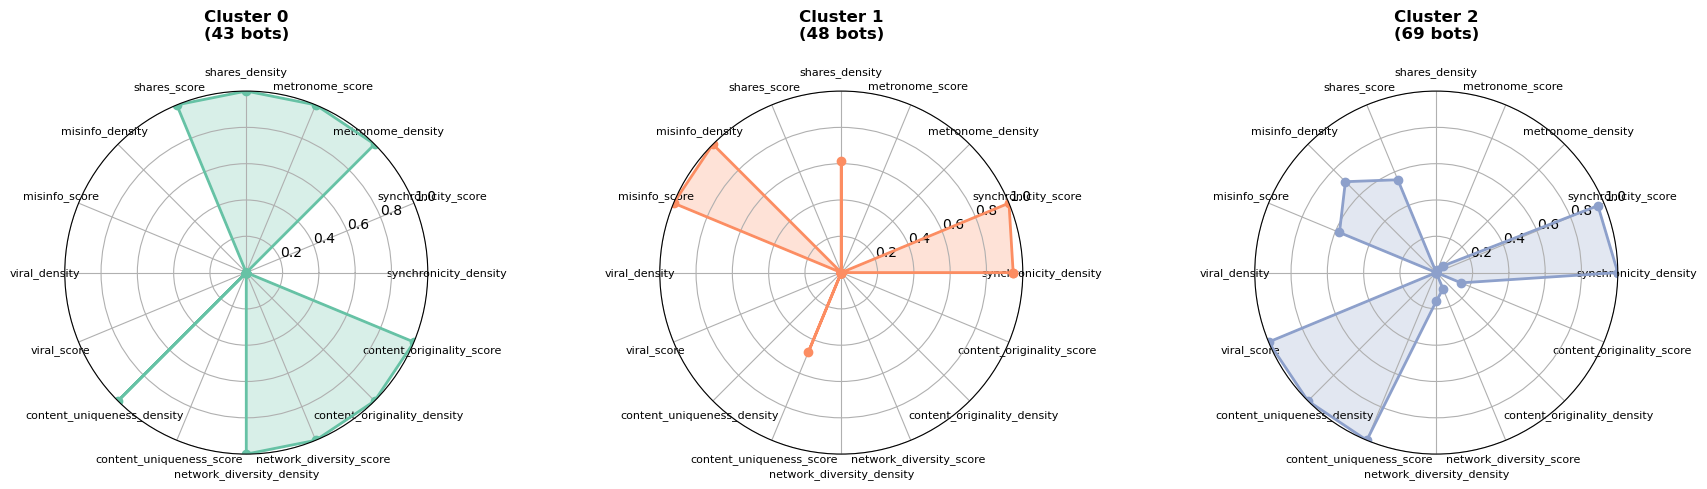

ANÁLISE DOS PONTOS DE RUÍDO (22 bots)
                             Ruído (média)  Clusters (média)  Diferença  Diferença %
synchronicity_density             0.350649          0.639286  -0.288636        -45.1
synchronicity_score               6.122086          4.311433   1.810654         42.0
metronome_density                 0.454023          0.093606   0.360417        385.0
metronome_score                   0.340890          0.069938   0.270953        387.4
shares_density                    0.113515          0.163053  -0.049538        -30.4
shares_score                      2.891006          3.078495  -0.187489         -6.1
misinfo_density                   0.239748          0.248772  -0.009024         -3.6
misinfo_score                     0.846460          1.061873  -0.215413        -20.3
viral_density                     0.181818          0.000000   0.181818          inf
viral_score                       0.797008          0.025516   0.771492       3023.6
content_uniqueness_density 

,synchronicity_density,synchronicity_score,metronome_density,metronome_score,shares_density,shares_score,misinfo_density,misinfo_score,viral_density,viral_score,content_uniqueness_density,content_uniqueness_score,network_diversity_density,network_diversity_score,content_originality_density,content_originality_score,Archetype_ID
f8cfdd1c4d35d23a5a76ca1d8a0e1294,0.0,0.000000,1.000000,0.629630,0.13874,2.456366,0.000000,0.000000,0.0,0.0,1.0,0.001647,0.533333,0.458333,0.0,0.072727,-1
b4a2c0a09761d5582f8ef1123718d434,1.0,0.693147,0.000000,0.000000,0.13874,3.376577,0.000000,0.000000,0.0,0.0,0.0,0.034415,0.118280,0.222222,0.0,0.000000,1
3b262fc9f742d702f0ad2d861cb9874c,0.0,0.000000,0.298851,0.363636,0.13874,2.519828,0.000000,0.000000,0.0,0.0,1.0,0.001408,0.346405,0.555556,1.0,0.058824,0
bdfe77ede80f93dd8877e698351feb60,0.0,0.000000,0.298851,0.272727,0.13874,3.388279,0.000000,0.000000,0.0,0.0,1.0,0.000651,0.346405,0.545455,1.0,0.058824,0
39cbaa62b92a0e15533df93733bad5aa,1.0,2.197225,0.000000,0.000000,0.13874,3.618676,0.459677,2.390935,0.0,0.0,1.0,0.024646,0.415205,0.098592,0.0,0.000000,2


In [17]:
df_features_clustered, archetype_dna, clusterer = apply_best_hdbscan(
    df_bots,
    min_cluster_size=15,
    min_samples=1,
    cluster_selection_epsilon=0.0
)

dna_scaled = visualize_archetypes_hdbscan(archetype_dna, df_features_clustered)

visualize_cluster_profiles(archetype_dna, df_features_clustered)

analyze_noise_points(df_features_clustered)

df_features_clustered.head()

In [18]:
dna_scaled.to_csv('visualization_archetypes.csv')